### Goals: 
(1) Use submission title + comments --> use cleaner data processing (lemmatizer, remove stop words)

(2) Compute the TF-IDF matrix and perform SVD decomposition to find topics

(3) Interpretability

In [71]:
import nltk
import tqdm
import fasttext
import itertools
import numpy as np
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.mode.chained_assignment = None 

#nltk.download('wordnet')
stop_words=set(nltk.corpus.stopwords.words('english'))
all_data = pd.read_csv('Data\submission_and_comments_V3.csv', sep = ";")
data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]

In [30]:
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    wor_tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in wor_tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

data['clean_submission_title'] = data['submission_title'].apply(clean_text)

In [5]:
vectorizer = TfidfVectorizer(stop_words = list(stop_words), max_df=0.95)
tf_idf = vectorizer.fit_transform(data['clean_submission_title'])

tf_idf.shape

(20514, 9713)

In [8]:
lsa_model = TruncatedSVD(n_components = 10, algorithm = "randomized", n_iter = 100, random_state = 42)
lsa_topics = lsa_model.fit_transform(tf_idf)
lsa_topics.shape

(20514, 10)

In [20]:
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(vocab, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    print(' '.join([t[0] for t in sorted_terms]))

Topic 0: 
social medium internet reddit time day addiction phone need quit
Topic 1: 
social medium media dilemma deleted business platform medias loop validation
Topic 2: 
day nosurf reddit time instagram hour 30 challenge deleted facebook
Topic 3: 
reddit deleting time account youtube help instagram delete need deleted
Topic 4: 
phone help need time dumb screen flip get app apps
Topic 5: 
help need day nosurf reddit advice please addiction youtube quitting
Topic 6: 
phone addiction dumb deleted instagram reddit flip deleting smart without
Topic 7: 
instagram deleted facebook account twitter finally feel delete deactivated snapchat
Topic 8: 
nosurf life new anyone feel starting journey start like else
Topic 9: 
youtube addiction quit nosurf video stop instagram discord watching channel


In [68]:
model_performance = []
topics_range = range(1, 2500, 250)

for n_comp in tqdm.tqdm(topics_range):
    lsa_model = TruncatedSVD(n_components = n_comp, algorithm = "randomized", n_iter = 10, random_state = 42)
    lsa_topics = lsa_model.fit_transform(tf_idf)
    model_performance.append(lsa_model.explained_variance_ratio_.sum())


100%|██████████| 10/10 [06:15<00:00, 37.51s/it]


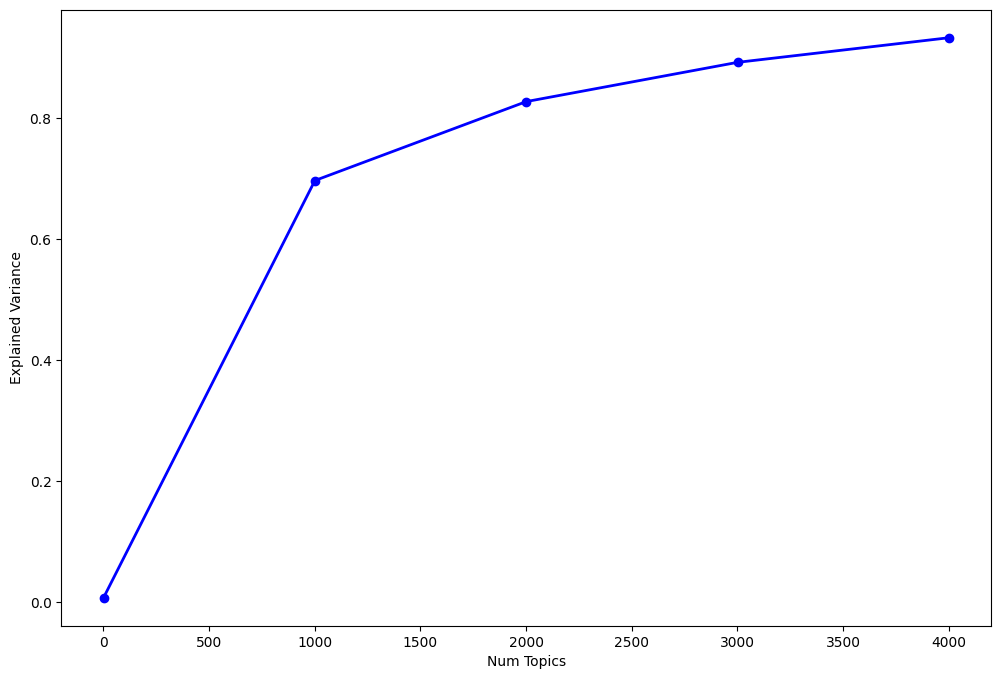

In [67]:
fig = plt.figure(figsize=(12, 8))
plt.plot(topics_range[:len(model_performance)], model_performance, 'o-', linewidth=2, color = 'blue')
plt.xlabel("Num Topics")
plt.ylabel("Explained Variance")
plt.show()

In [32]:
save_txt_path = 'Data/clean_comments_text.txt'
concat_posts = np.array(data['clean_submission_title'])
np.savetxt(save_txt_path, concat_posts, fmt='%s', encoding="utf-8")

model = fasttext.train_unsupervised("Data/comments_text.txt", model='cbow')
model.save_model("Models/clean_cbow_model.bin")

In [33]:
embbed_data = [model[post] for post in concat_posts]

In [41]:
model_performance = []
topics_range = range(1, 100, 1)

for n_comp in tqdm.tqdm(topics_range):
    lsa_model = TruncatedSVD(n_components = n_comp, algorithm = "randomized", n_iter = 10, random_state = 42)
    lsa_topics = lsa_model.fit_transform(embbed_data)
    model_performance.append(lsa_model.explained_variance_ratio_.sum())

100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


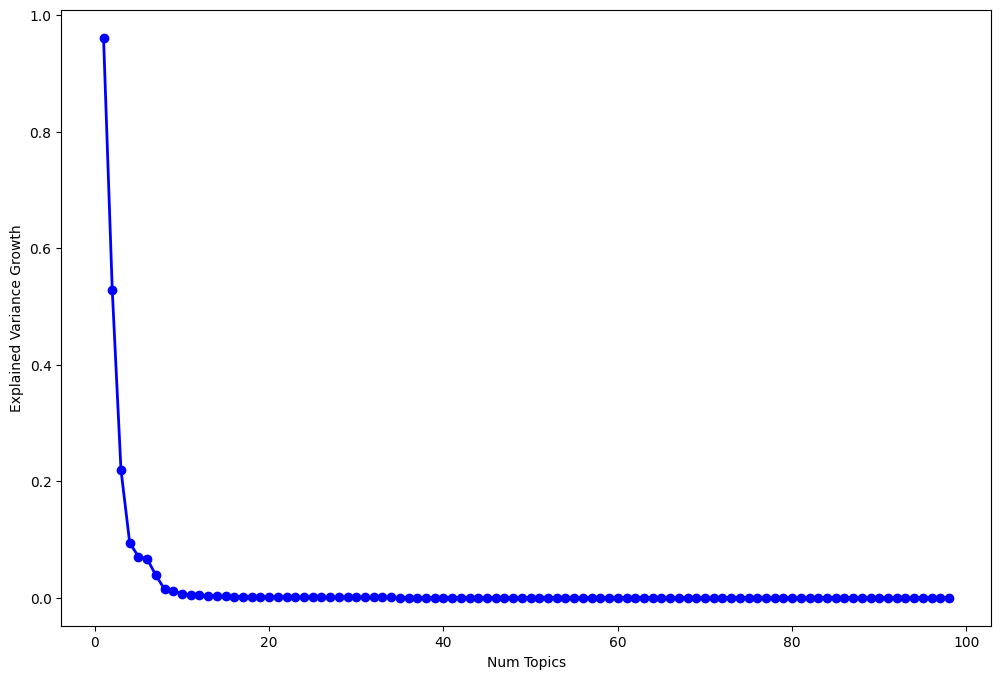

In [50]:
fig = plt.figure(figsize=(12, 8))
plt.plot(topics_range[:len(model_performance)-1], np.diff(model_performance)/model_performance[:-1]*100, 'o-', linewidth=2, color = 'blue')
plt.xlabel("Num Topics")
plt.ylabel("Explained Variance Growth")
plt.show()

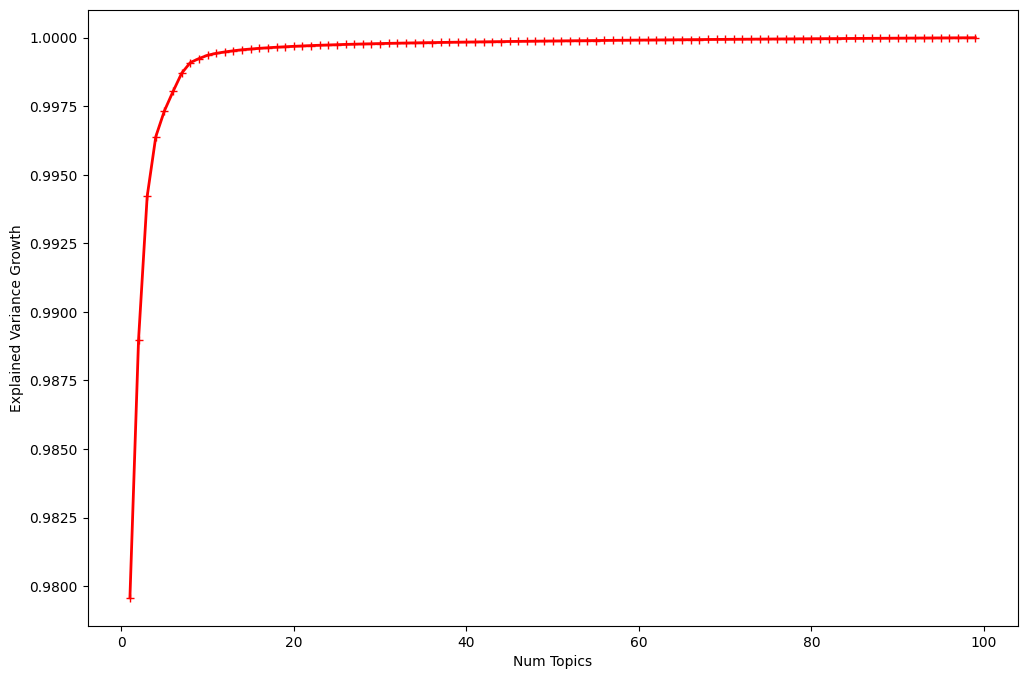

In [53]:
fig = plt.figure(figsize=(12, 8))
plt.plot(topics_range[:len(model_performance)], model_performance, '+-', linewidth=2, color = 'red')
plt.xlabel("Num Topics")
plt.ylabel("Explained Variance Growth")
plt.show()

In [49]:
# do the method we did before to explain the topics


## NEXT STEPS
# Run LDA on the data
# Autoencoders to visualize the topics (cosine?)
# Stats on topics [size, number of words in each sentence, sentiment analysis]
# Predict the number of commments --> Shapley values

## Give a summary of the main topics and core concepts
## Automate anomaly detection system
## Reply system?

In [55]:
lsa_model = TruncatedSVD(n_components = 10, algorithm = "randomized", n_iter = 10, random_state = 42)
lsa_topics = lsa_model.fit_transform(embbed_data)

lsa_topics.shape

(20514, 10)

In [65]:
def K_furthest_points(list_vecs, Npoints = 3):
    data = np.matrix(list_vecs)
    c = [list(x) for x in itertools.combinations(range(len(data)), Npoints )]
    distances = []
    for i in c:    
        distances.append(np.mean(pdist(data[i,:]))) # pdist: a method of computing all pairwise Euclidean distances in a condensed way.
    ind = distances.index(max(distances)) # finding the index of the max mean distance
    rows = c[ind] # these are the points in question
    return rows

def closest3_words(vec, top_k):
    similarities =  [cosine(vec, model[w]) for w in model.words]
    top_sims = [model.words[ind] for ind in np.argsort(similarities)[: top_k]]
    print("Top similar words: ")
    print(top_sims)
    top_sims_vectors = [model[w] for w in top_sims]
    topk_furtherst_points = K_furthest_points(top_sims_vectors, Npoints = 3)
    return [top_sims[point] for point in topk_furtherst_points]


for i,comp in enumerate(lsa_model.components_):
    print(f"Topic {i}:")
    print(closest3_words(comp, 10))

Topic 0:
Top similar words: 
['Abstinence', 'kinda', 'Take', 'controlled', 'business', 'kinds', 'routine?', 'wrong?', 'quarantine?', 'laptop']
['controlled', 'wrong?', 'laptop']
Topic 1:
Top similar words: 
['Using', 'using', 'lying', 'Being', 'being', 'thing', 'Doing', 'going', 'doing', 'Losing']
['thing', 'going', 'Losing']
Topic 2:
Top similar words: 
['deleted', 'deleting', 'delete', 'Deleted', 'Deleting', 'account', 'account,', 'account.', 'accounts.', 'account?']
['deleting', 'account', 'accounts.']
Topic 3:
Top similar words: 
['blocking', 'block', 'block.', 'blocker?', 'blocks', 'Blocking', 'Turkey', 'locking', 'blocker', 'turkey']
['blocker?', 'locking', 'turkey']
Topic 4:
Top similar words: 
['day', 'hours', 'days', '35', 'phone', 'week', 'day.', 'days!6', 'hour', 'hours,']
['day', '35', 'phone']
Topic 5:
Top similar words: 
['Surf', '"NoSurf', 'Social', 'NoSurf', 'NoSurf.', 'Day', '"social', 'Commitment', 'day', 'Continue']
['"NoSurf', 'Social', 'day']
Topic 6:
Top similar w

In [63]:
lsa_model.components_.shape

(10, 100)